# Importing ONNX models to Tensorflow

We'll show how you can use ONNX-Tensorflow to import ONNX models into Tensorflow, and use the imported model for inference.

## Step 1: Installation

First install [ONNX](https://github.com/onnx/onnx) and [Tensorflow](https://github.com/tensorflow/tensorflow) by following the instructions on each of their repository.

Then, install the ONNX-Tensorflow package:
```  
git clone git@github.com:onnx/onnx-tensorflow.git && cd onnx-tensorflow
pip install -e .
```

## Step 2: Prepare an ONNX model to import

In this example, we will demonstrate importing a Super Resolution model, designed to increase the spatial resolution of images. The model was built and trained with PyTorch, and exported into ONNX using Pytorch's ONNX export API. More details about the model design are available in Pytorch's example.

## Step 3: Import the ONNX model into Tensorflow

Now that we have an ONNX model file ready, let's import it into Tensorflow using ONNX-Tensorflow's import API.

In [1]:
import onnx
import warnings
from onnx_tf.backend import prepare

warnings.filterwarnings('ignore') # Ignore all the warning messages in this tutorial
model = onnx.load('assets/super_resolution.onnx') # Load the ONNX file
tf_rep = prepare(model) # Import the ONNX model to Tensorflow

Now we have `tf_rep`, which is a python class containing four members: `graph`, `inputs`, `outputs`, and `tensor_dict`.

In [2]:
print(tf_rep.inputs) # Input nodes to the model
print('-----')
print(tf_rep.outputs) # Output nodes from the model
print('-----')
print(tf_rep.tensor_dict) # All nodes in the model

['1']
-----
['27']
-----
{'27': <tf.Tensor 'Reshape_1:0' shape=(1, 1, 672, 672) dtype=float32>, '24': <tf.Tensor 'Add_3:0' shape=(1, 9, 224, 224) dtype=float32>, '15': <tf.Tensor 'concat_1:0' shape=(1, 64, 224, 224) dtype=float32>, '17': <tf.Tensor 'Relu_1:0' shape=(1, 64, 224, 224) dtype=float32>, '7': <tf.Tensor 'Const_5:0' shape=(32,) dtype=float32>, '21': <tf.Tensor 'Relu_2:0' shape=(1, 32, 224, 224) dtype=float32>, '2': <tf.Tensor 'Const:0' shape=(64, 1, 5, 5) dtype=float32>, '9': <tf.Tensor 'Const_7:0' shape=(9,) dtype=float32>, '19': <tf.Tensor 'concat_2:0' shape=(1, 32, 224, 224) dtype=float32>, '20': <tf.Tensor 'Add_2:0' shape=(1, 32, 224, 224) dtype=float32>, '6': <tf.Tensor 'Const_4:0' shape=(32, 64, 3, 3) dtype=float32>, '3': <tf.Tensor 'Const_1:0' shape=(64,) dtype=float32>, '5': <tf.Tensor 'Const_3:0' shape=(64,) dtype=float32>, '12': <tf.Tensor 'Add:0' shape=(1, 64, 224, 224) dtype=float32>, '4': <tf.Tensor 'Const_2:0' shape=(64, 64, 3, 3) dtype=float32>, '1': <tf.Tensor

## Step 4: Prepare input for inference

Next, we will prepare an input image for inference. The steps below downloads an example image, resizes it to the model's expected input shape, and finally converts it into a numpy array.

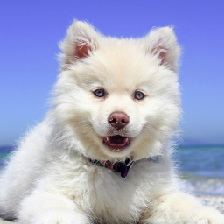

In [3]:
import numpy as np
from IPython.display import display
from PIL import Image

img = Image.open('assets/super-res-input.jpg').resize((224, 224))
display(img) # show the image
img_ycbcr = img.convert("YCbCr")
img_y, img_cb, img_cr = img_ycbcr.split()
doggy_y = np.asarray(img_y, dtype=np.float32)[np.newaxis, np.newaxis, :, :]

## Step 5: Run the network!


In [4]:
big_doggy = tf_rep.run(doggy_y)._0
print(big_doggy.shape)

(1, 1, 672, 672)


## Step 6: Examine the results

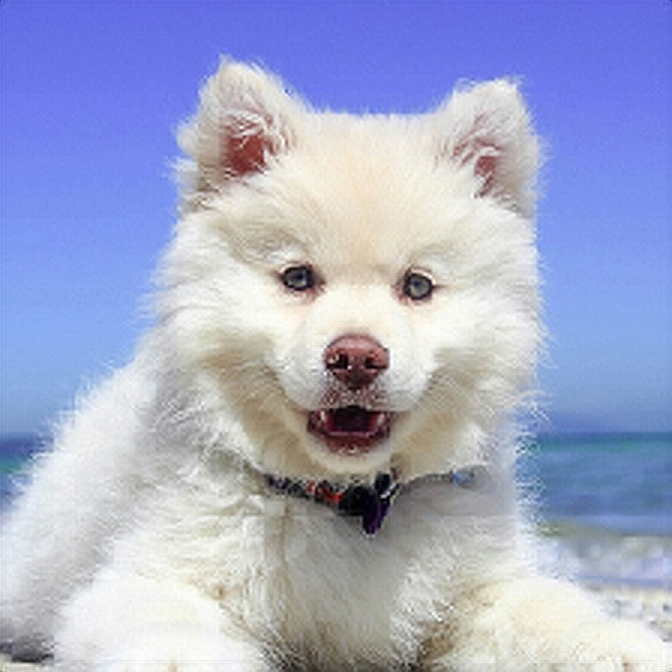

In [5]:
img_out_y = Image.fromarray(np.uint8(big_doggy[0, 0, :, :].clip(0, 255)), mode='L')
result_img = Image.merge("YCbCr", [
    img_out_y,
    img_cb.resize(img_out_y.size, Image.BICUBIC),
    img_cr.resize(img_out_y.size, Image.BICUBIC),
]).convert("RGB")
display(result_img)
result_img.save('output/super_res_output.jpg')